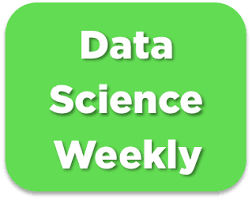

# Conversion Rate - Introduction

Les data scientists qui ont créé la newsletter aimeraient mieux comprendre le comportement des utilisateurs qui visitent leur site web. Ils aimeraient savoir s'il est possible de construire un modèle qui prédit si un utilisateur donné va s'abonner à la newsletter, en utilisant seulement quelques informations sur l'utilisateur. Ils aimeraient analyser les paramètres du modèle pour mettre en évidence les caractéristiques qui sont importantes pour expliquer le comportement des utilisateurs, et peut-être découvrir un nouveau levier d'action pour améliorer le taux de conversion de la newsletter.

C'est ce que nous allons voir ci-dessous, en réalisant une première partie consacrée à l'exploration des données, et à partir de ses conclusions nous pourrons tester plusieurs modèles de machine learning supervisé.

### Import libraries

In [141]:
!pip install plotly -q

In [142]:
!pip install -U kaleido -q

In [210]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error,classification_report

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

## 1- EDA et Data visualisation

### Read file with labels

In [144]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [145]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


Déjà, nous pouvons constater que le nombre de variables du dataset à explorer et à modéliser est restreint : 5 (la sixième, le nombre de convertis étant notre valeur cible, celle que nous tenterons de prédire)

Nous allons donc étudier ces variables, soit : le pays de l'étude, l'âge de l'utilisateur, source (type de médias), nombres de pages visités, et si l'utilisateur est un nouvel utilisateur, ou non.


### Explore dataset

In [147]:
# le dataset étant très important, nous allons donc ici en sélectionner un échantillon afin de réaliser notre étude.
#df = data.sample(10000)

In [148]:
data.describe()

,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [149]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [150]:
#Nombre de pays représentés :
data['country'].value_counts()

US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64

L'étude se porte sur 4 pays ; et nous pouvons constaté une disparité, une représentation déséquilibrée dans les pays : Les Etats-Unis étant par exemple, massivement représentés, suivi de la Chine ; l'Allemagne quant à elle est beaucoup moins représentée, près de 13 fois moins que les US.

In [151]:
#Nombre de sources - média représenté :
data["source"].value_counts()

Seo       139477
Ads        80027
Direct     65076
Name: source, dtype: int64

In [152]:
# Nombre d'utilisateur par source, par pays
country_source=data.groupby(["country"])['source'].value_counts()
country_source

country  source
China    Seo       33879
         Ads       19519
         Direct    15724
Germany  Seo        5752
         Ads        3379
         Direct     2562
UK       Seo       21450
         Ads       12170
         Direct    10021
US       Seo       78396
         Ads       44959
         Direct    36769
Name: source, dtype: int64

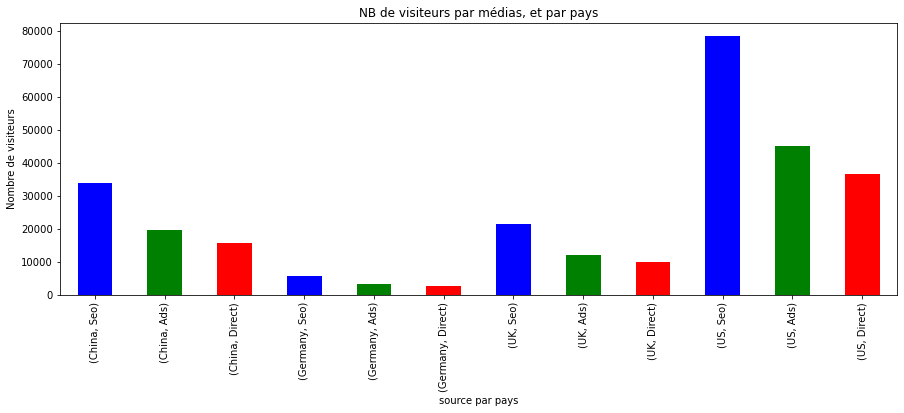

In [153]:
country_source.plot(kind='bar',
                    title='NB de visiteurs par médias, et par pays',
                    ylabel='Nombre de visiteurs',
                    xlabel='source par pays',
                    color=['b','g','r'],
                    figsize=(15, 5),
                    legend = False)
plt.show()

Nous pouvons constasté ici que quelque soit le pays, les sources les plus visitées sont SEO, suivi de ADS et Direct...

In [154]:
#Nombre de conversion / ensemble des utilisateurs
users=data["converted"].value_counts().sum()
conversion=data["converted"].sum()
ratio= round(conversion/users,3)
print(f"Nombre d'utilisateurs : {users},\n Nombre de conversion : {conversion},\n Ratio conversion/ nbre d'utilisateurs : {ratio}")

Nombre d'utilisateurs : 284580,
 Nombre de conversion : 9180,
 Ratio conversion/ nbre d'utilisateurs : 0.032


Nous pouvons constater un faible taux de conversion par rapport aux nombres d'utilisateurs, puisqu'il est de 0.03%

In [158]:
# Nombre de nouveaux uilisateurs
data.groupby(["new_user"]).count()

,country,age,source,total_pages_visited,converted
new_user,,,,,
0,89514,89514,89514,89514,89514
1,195066,195066,195066,195066,195066


Sur l'ensemble des utilisateurs soit 284 580, on constate que 195 065 sont de nouveaux utilisateurs, donc une grande majorité de l'étude proposée.

Nous allons donc nous intéresser au ratio de convertis chez les nouveaux utilisateurs, 

In [160]:
#Nombre de conversion / nouveaux utilisateurs
users=data["new_user"].sum()
mask = (data['converted'] == 1)
true_converted = data.loc[mask,:]
mask2=(true_converted['new_user']==1)
data_converted=true_converted.loc[mask2,:]
conversion = data_converted["new_user"].count()
ratio= round(conversion/users,3)
print(f"Nombre d'utilisateurs : {users} \n Nombre de conversion : {conversion} \n Ratio conversion/ nbre d'utilisateurs : {ratio}")

Nombre d'utilisateurs : 195066 
 Nombre de conversion : 2741 
 Ratio conversion/ nbre d'utilisateurs : 0.014


In [161]:
#Nombre de conversion / autres utilisateurs
mask_user=data['new_user']==0
data1=(data.loc[mask_user,:])
users = data1['new_user'].value_counts()

mask = (data1['converted'] == 1)
true_converted = data1.loc[mask,:]

conversion = true_converted["new_user"].count()
ratio= round(conversion/users,3)
print(f"Nombre d'utilisateurs qui ne sont pas nouveaux : {users},\n Nombre de conversions parmi eux : {conversion},\n Ratio conversion/ nbre d'utilisateurs : {ratio}")

Nombre d'utilisateurs qui ne sont pas nouveaux : 0    89514
Name: new_user, dtype: int64,
 Nombre de conversions parmi eux : 6439,
 Ratio conversion/ nbre d'utilisateurs : 0    0.072
Name: new_user, dtype: float64


Il apparait ici qu'il y a beaucoup plus de nouveaux utilisateurs (195 066) que d'anciens utilisateurs (89 514), le taux de conversion est bien plus important chez les anciens utilisateurs que les nouveaux (près du double), soit 0.07 contre 0.015 pour les nouveaux utilisateurs.

In [162]:
# calcul du nombre de convertis par pays en moyenne
df_country=df.groupby(['country']).mean()
df_country

,age,new_user,total_pages_visited,converted
country,,,,
China,30.565789,0.696957,4.564145,0.002056
Germany,30.720000,0.680000,5.370667,0.069333
UK,30.508575,0.683377,5.135884,0.048153
US,30.565439,0.694557,4.943984,0.035758


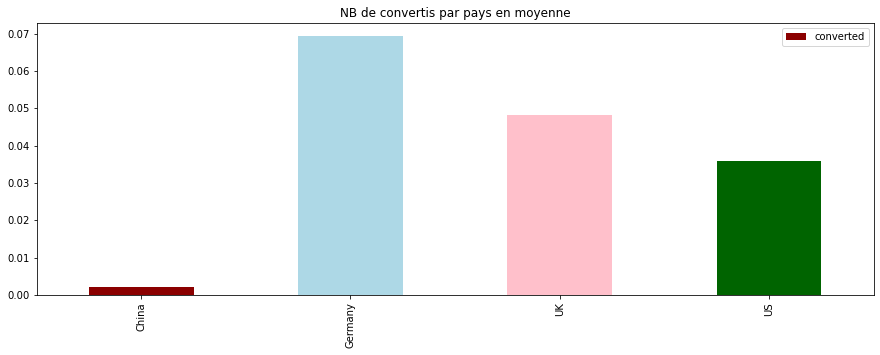

In [163]:
df_country['converted'].plot(kind='bar',
                    title='NB de convertis par pays en moyenne',
                    ylabel='',
                    xlabel='',
                    color=['darkred','lightblue','pink','darkgreen'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

Ici, nous pouvons voir que le nombre de conversion est plus important en Allemagne, suivi du Royaume-Uni, suivi des États-Unis, enfin de la Chine. On peut constater que ce nombre de conversions est le plus important dans les pays les moins représentés de cette étude.

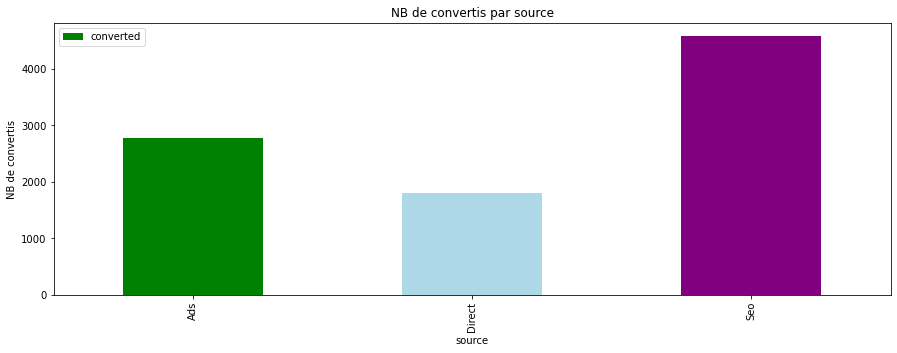

In [164]:
# Calcul du nombre de convertis par source
mask = (data['converted'] == 1)
true_converted = data.loc[mask,:]

data_pays = true_converted.groupby(['source']).count()
data_pays['converted'].plot(kind='bar',
                    title='NB de convertis par source',
                    ylabel='NB de convertis',
                    xlabel='source',
                    color=['green','lightblue','purple'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

Les conversions sont plus importantes sur les médias SEO, suivi de ADS et Direct. On constate ici une similarité de résultats par rapport aux sources qui ont le plus d'utilisateurs.

In [165]:
#un autre critère est l'êge que nous allons explorer ci-dessous :

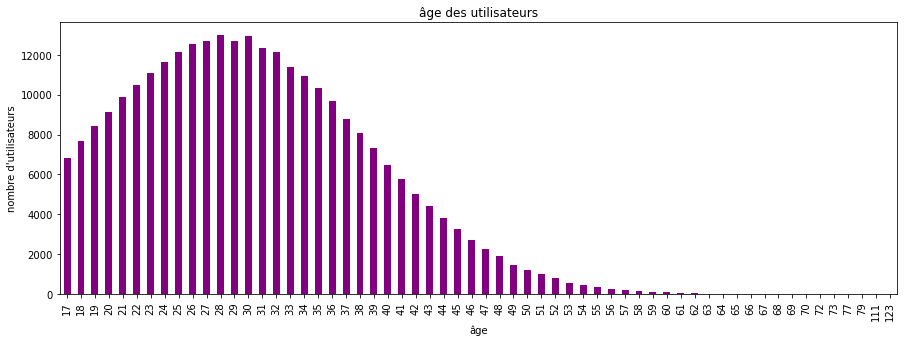

In [177]:
#représentation de l'âge des utilisateurs :
df_converted = data.groupby(['age']).count()
df_converted['converted'].plot(kind='bar',
                    title='âge des utilisateurs',
                    ylabel="nombre d'utilisateurs",
                    xlabel='âge',
                    color=['purple'],
                    figsize=(15, 5),
                    legend = False)
plt.show()

Nous constatons que les âges varients entre 17 et 62 ; qu'il y a une présence de valeurs aberrantes (63 ans),  et nous pouvons déterminer que l'âge moyen des utilisateurs se situe aux alentours de 29-30 ans. 

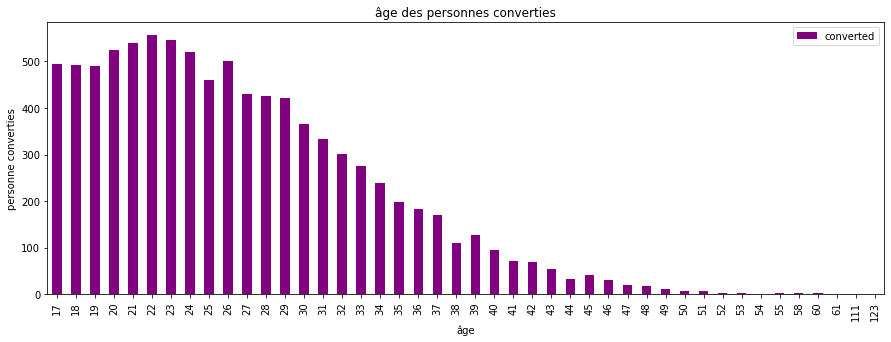

In [179]:
# Représentation de l'äge des convertis :
masq = (data['converted'] == 1)
true_converted = data.loc[masq,:]
true_converted

df_converted = true_converted.groupby(['age']).count()
df_converted['converted'].plot(kind='bar',
                    title='âge des personnes converties',
                    ylabel='personne converties',
                    xlabel='âge',
                    color=['purple'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

L'âge des utilisateurs convertis varient lui entre 17 et 37 ans... Par rapport à l'histogramme des âges des utilisateurs, on constate que la tranche d'âge
entre 17 et 24/26 ans est sur-représentées chez les peronnes converties.

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='age', ylabel='Density'>

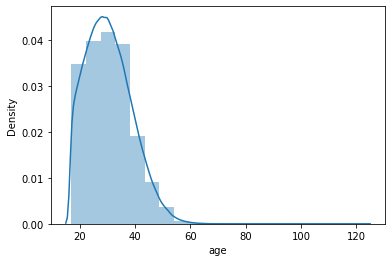

In [180]:
sns.distplot(data['age'],bins=20)
#sns.catplot(x="converted", y="age", data=data_sample)

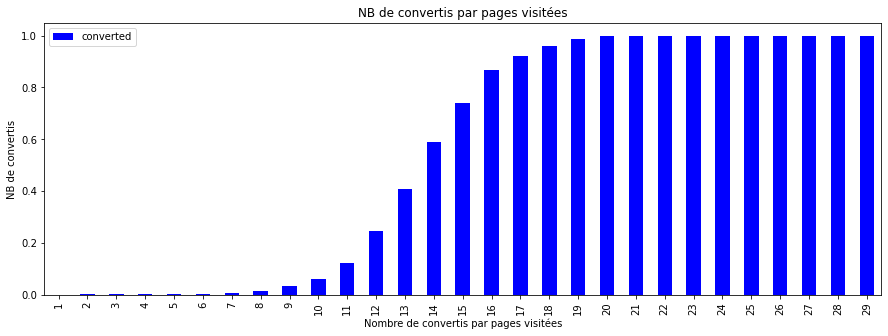

In [187]:
#Nombres de convertis par pages visitées, répartition par âge
masq = (data['converted'] == 1)
true_converted = data.loc[masq,:]
true_converted

df_converted = data.groupby(['total_pages_visited']).mean()
df_converted['converted'].plot(kind='bar',
                    title='NB de convertis par pages visitées',
                    ylabel='NB de convertis',
                    xlabel='Nombre de convertis par pages visitées',
                    color=['blue'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

On constate une augmentation des conversions après 8, 9 pages visities et une conversion supérieure à 80 % lorsque plus de 17 pages ont été visitées.

### Première conclusions de l'exploration de données :

L'exploration de données nous donne quelques indications concernant le projet. On constate que les données sont très variées, non uniforme (différents pays, donc potentiellement des biais), et qu'une des variables est délicate à manipuler : en effet, on sait que plus les utilisateurs consultent un nombre de pages importants, plus ils ont tendance à se convertir. Mais c'est une information que l'on a posteriori. C'est une fois qu'il y a conversion que l'on constate cela, mais on ne peut pousser à consulter des pages... Donc, une donnée qui mérite qu'on s'y attarde afin de tirer quelques conclusions quant à son utilisation.
Enfin, on constate que le jeu de données est très déséquilibré, puisqu'il y a une majorité écrasante de non- converti, ce qui va être un biais pour l'apprentissage dans notre modèle.

# Modèles de prédictions

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [188]:
#on definit X et Y - Y étant la prédiction que nous cherchons à atteindre, soit la conversion de l'utilisateurs.
target_name = 'converted'
Y = data.loc[:,target_name]
X = data.loc[:,[c for c in df.columns if c!=target_name]]
print(X)
# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

        country  age  new_user  source  total_pages_visited
0         China   22         1  Direct                    2
1            UK   21         1     Ads                    3
2       Germany   20         0     Seo                   14
3            US   23         1     Seo                    3
4            US   28         1  Direct                    3
...         ...  ...       ...     ...                  ...
284575       US   36         1     Ads                    1
284576       US   31         1     Seo                    2
284577       US   41         1     Seo                    5
284578       US   31         1  Direct                    4
284579       US   26         0     Ads                    3

[284580 rows x 5 columns]


In [189]:
#Conversion de pandas dataframe en numpys array...
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

In [196]:
# Creation d'un pipeline pour les catégories numériques
numeric_features = [1, 4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Remplacement des valeurs manquantes par la moyenne de la colonne
    ('scaler', StandardScaler())
])

In [197]:
# Creation d'un pipeline pour les catégories numériques
categorical_features = [0, 2, 3] # Position des colonnes dites catégoriques dans X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # si baleurs manquantes, remplacement par la valeur la plus fréquente
    ('encoder', OneHotEncoder(drop='first')) # on "drop" la première colonne afin d'éviter de créer des corrélations entre les features
    ])

In [198]:
#OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train and test set
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) # Don't fit again on test!!

### training et test pipeline - Logistic regression

In [199]:
# Train model
classifierR = LogisticRegression()
classifierR.fit(X_train, Y_train) # Training is always done on train set !!

# Predictions on training set
y_train_pred = classifierR.predict(X_train)
# Predictions on test set
y_test_pred = classifierR.predict(X_test)

In [200]:
print("f1-score on train set : %.3f" % f1_score(Y_train, y_train_pred))
print("f1-score on test set : %.3f" % f1_score(Y_test, y_test_pred))

f1-score on train set : 0.765
f1-score on test set : 0.758


Test set
La matrice de confusion montre que le modèle semble assez robuste sur l'ensemble de test aussi


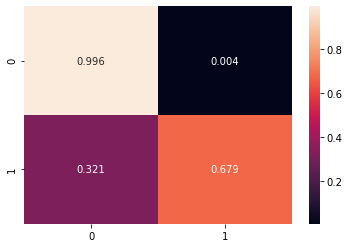

In [201]:
print('Test set')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt=".3f");
print("La matrice de confusion montre que le modèle semble assez robuste sur l'ensemble de test aussi")

Dans les données de test, le nombre de non-convertis classés comme non-convertis est de 99.6 %

Le nombre de convertis classé comme converti est correct à 68 %

On constate également 32% de faux-négatifs, c'est-à-dire 32% où les convertis sont classés en non-convertis.

In [205]:
# Computing other performance metrics to better understand what the model is doing : Classifier
print(classification_report(Y_test, classifierR.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55066
           1       0.86      0.68      0.76      1850

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



Nous avons donc un score de "précision", c'est-à-dire la probabilité de prédire la bonne valeur de conversions : 99 % de non-conversion, et 86% de non-conversion, comme étant juste.

le Recall à 1.00 signifie que nous prédisons à 100 % le nombre de non-convertis, et 68 % de prédiction positive pour les convertis.

le F-1 score calcule la moyenne des métriques de chaque catégories, soit précision et recall, avec un score de 99% pour les non-converti et 76 % pour les convertis.

On retrouve ici la problématique de déséquilibre du dataset, avec un taux de non-conversion extrêmement plus important que celui des conversion, qui n'est pas optimum pour l'apprentissage.

In [19]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



### training et test pipeline - Arbre de décision

In [208]:
# Creation d'un arbre de décision
classifier = DecisionTreeClassifier()
classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [211]:
# Recherche des meilleurs hyperparametres - avec gridSearchCV
max_depth = [7, 8, 9,10]
min_samples_split = [10,11,12,13]

dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(), cv=3,
                       param_grid={"max_depth":max_depth, "min_samples_split":min_samples_split})

dt_grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_samples_split': [10, 11, 12, 13]})

In [212]:
print("Hyperparameters that give the best score : ", dt_grid.best_params_)
print("Best score : %.3f" % dt_grid.best_score_)

Hyperparameters that give the best score :  {'max_depth': 8, 'min_samples_split': 12}
Best score : 0.985


In [213]:
# Apply the grid search outputs into the Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=dt_grid.best_params_['max_depth'],
                           min_samples_split=dt_grid.best_params_['min_samples_split'])
dt.fit(X_train, Y_train)

# Predictions on training set
y_train_pred = dt.predict(X_train)

# Predictions on test set
y_test_pred = dt.predict(X_test)

In [214]:
# The f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : %.3f" % f1_score(Y_train, dt.predict(X_train)))
print("f1-score on test set : %.3f" % f1_score(Y_test, dt.predict(X_test)))

f1-score on train set : 0.764
f1-score on test set : 0.748


TEST SET : Decision TREE
---
The confusion matrix shows that the model random tree seems pretty robust on test set!


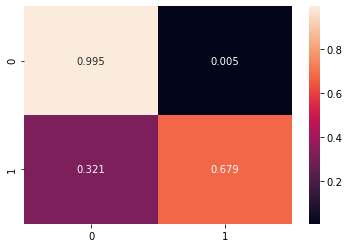

In [215]:
print('TEST SET : Decision TREE')
print('---')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");
print('The confusion matrix shows that the model random tree seems pretty robust on test set!')

Dans les données de test, le nombre de non convertis classé comme non convertis corespond à 99,5 %. Dans les données de test, le nombre de convertis classé comme convertis est correct à 67 %.

Nous avons toujours un biais ou erreur avec un taux de 32 % de convertis classés comme non convertis

In [216]:
# autres métriques de performance avant de mieux comprendre notre modèle : random tree
print(classification_report(Y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55066
           1       0.83      0.68      0.75      1850

    accuracy                           0.99     56916
   macro avg       0.91      0.84      0.87     56916
weighted avg       0.98      0.99      0.98     56916



Nous constatons ici des valeurs à peu près équivalentes à celles que nous avions trouvées avec la régression logistique. Néanmoins, elles sont légèrement plus faibles quant à la prédiction des convertis, avec une F-1 score à 75 % contre 76 %

### Training et test pipeline - Random Forest

In [218]:
#Instanciation du random forest
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)

RandomForestClassifier()

In [219]:
# Determining best hyperparameters
max_depth = [9,10,15,20]
min_samples_split = [40,50,60,70]
n_estimators = (45,50,60,70)

rf_grid = GridSearchCV(estimator=RandomForestClassifier(), cv=3,
                       param_grid={"max_depth":max_depth,
                                   "min_samples_split":min_samples_split,
                                   "n_estimators":n_estimators})

rf_grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [9, 10, 15, 20],
                         'min_samples_split': [40, 50, 60, 70],
                         'n_estimators': (45, 50, 60, 70)})

In [220]:
print("Hyperparameters that give the best score : ", rf_grid.best_params_)
print("Best score : %.3f" % rf_grid.best_score_)

Hyperparameters that give the best score :  {'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 70}
Best score : 0.986


In [221]:
rf = RandomForestClassifier(n_estimators = rf_grid.best_params_['n_estimators'], max_depth=rf_grid.best_params_['max_depth'],
                           min_samples_split=rf_grid.best_params_['min_samples_split'])
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=9, min_samples_split=40, n_estimators=70)

In [222]:
rf_grid.best_params_

{'max_depth': 9, 'min_samples_split': 40, 'n_estimators': 70}

In [223]:
# Predictions on training set
y_train_pred = rf.predict(X_train)

# Predictions on test set
y_test_pred = rf.predict(X_test)

In [224]:
print("f1-score on train set : %.3f" % f1_score(Y_train, rf.predict(X_train)))
print("f1-score on test set : %.3f" % f1_score(Y_test, rf.predict(X_test)))

f1-score on train set : 0.769
f1-score on test set : 0.753


TEST SET : RANDOM FOREST
---


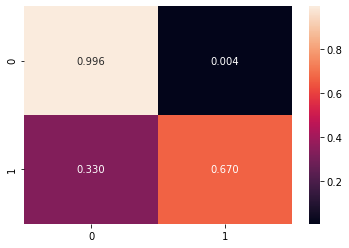

In [225]:
print('TEST SET : RANDOM FOREST')
print('---')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");

In [226]:
# Computing other performance metrics to better understand what the model is doing : random forest
print(classification_report(Y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55066
           1       0.86      0.67      0.75      1850

    accuracy                           0.99     56916
   macro avg       0.92      0.83      0.87     56916
weighted avg       0.98      0.99      0.98     56916



Nous retrouvons ici de nouveaux des scores approchant ce que nous avions déjà trouver dans les modèles précédents, mais sans augmentation réelle de la précision ou du F-1. De surcroit, nous retrouvons également le biais que nous avions de 33 % de faux-positifs, soit de convertis classés en non-convertis

Nous pouvons donc dire parmi notre trois modèles testés, aucun ne se détache réellement en tant que tel. La régression logistique, reste encore le modèle donnant le meilleur résultat

## Utilisation du meilleur modèle sur toutes les données

In [227]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifierR.fit(X,Y)

LogisticRegression()

In [229]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

#features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, data_without_labels.columns]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [230]:
# Create pipeline for categorical features
categorical_features = [0, 2, 3]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if still missing values we will replace by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Create pipeline for numeric features
numeric_features = [1, 4] 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # if still missing values we will replace by columns' mean
    ('scaler', StandardScaler())
])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_without_labels = preprocessor.fit_transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

...Done
[[-0.31512217  3.33913917  0.          1.          0.          0.
   0.          1.        ]
 [-1.03657046  0.03888347  0.          1.          0.          1.
   1.          0.        ]
 [ 0.16584336 -1.16120951  0.          0.          0.          1.
   0.          1.        ]
 [ 0.16584336  0.33890671  0.          0.          1.          1.
   0.          0.        ]
 [-0.67584631 -0.56116302  0.          0.          0.          0.
   0.          1.        ]]


In [231]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifierR.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)
